## ARIMA model - AutoRegressive Integrated Moving Average model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
# Load Hoboken Area Price
df = pd.read_csv('../pre_data/Hoboken_price.csv')

In [3]:
data = df.set_index('date')
data.index = pd.DatetimeIndex(data.index)

In [4]:
data.head()

,price
date,
2010-11-01,2534.0
2010-12-01,2553.0
2011-01-01,2553.0
2011-02-01,2539.0
2011-03-01,2525.0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 99 entries, 2010-11-01 to 2019-01-01
Data columns (total 1 columns):
price    99 non-null float64
dtypes: float64(1)
memory usage: 1.5 KB


In [6]:
# Select the best diff (Integrated)
from statsmodels.tsa.stattools import adfuller as ADF

print(ADF(data['price']))

(-1.8704519883857313, 0.346086508425379, 10, 88, {'1%': -3.506944401824286, '5%': -2.894989819214876, '10%': -2.584614550619835}, 588.6211908693606)


In [7]:
diff_1 = data.diff(1)
diff_1 = diff_1.dropna()
diff_1.columns = ['price_integrated']
print(ADF(diff_1['price_integrated']))

(-1.7012039439152993, 0.43049227574251736, 9, 88, {'1%': -3.506944401824286, '5%': -2.894989819214876, '10%': -2.584614550619835}, 585.0102940942284)


In [8]:
diff_2 = diff_1.diff(1)
diff_2 = diff_2.dropna()
diff_2.columns = ['price_integrated']
print(ADF(diff_2['price_integrated']))

(-6.156992729182019, 7.327774183151908e-08, 8, 88, {'1%': -3.506944401824286, '5%': -2.894989819214876, '10%': -2.584614550619835}, 579.136056583644)


In [9]:
from statsmodels.stats.diagnostic import acorr_ljungbox

noiseRes = acorr_ljungbox(diff_2, lags=1)
print(noiseRes)

(array([21.7257814]), array([3.14535623e-06]))


In [10]:
# Select the best AR(p) and MA(q)
from statsmodels.tsa.arima_model import ARMA

def proper_model(data, maxLag): 
    init_bic = float("inf")
    init_p = 0
    init_q = 0
    init_properModel = None
    for p in np.arange(maxLag):
        for q in np.arange(maxLag):
            model = ARMA(data, order=(p, q), freq='MS')
            try:
                results_ARMA = model.fit(disp=-1, method='css')
            except:
                continue
            bic = results_ARMA.bic
            if bic < init_bic:
                init_p = p
                init_q = q
                init_properModel = results_ARMA
                init_bic = bic
    return init_bic, init_p, init_q, init_properModel

In [11]:
p,q = proper_model(data, 8)[1:3]

/Users/ryne/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/ryne/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/ryne/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/ryne/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/ryne/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInv

In [12]:
print(p,q)

5 2


In [13]:
from statsmodels.tsa.arima_model import ARIMA

# Build ARIMA() model
model = ARIMA(data, (p,2,q), freq='MS')
arima_result = model.fit()

In [14]:
arima_result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: ARIMA
====================================================================
Model:              ARIMA            BIC:                 705.3118  
Dependent Variable: D2.price         Log-Likelihood:      -332.07   
Date:               2019-03-27 22:28 Scale:               1.0000    
No. Observations:   97               Method:              css-mle   
Df Model:           8                Sample:              01-01-2011
Df Residuals:       89                                    01-01-2019
Converged:          1.0000           S.D. of innovations: 7.336     
No. Iterations:     25.0000          HQIC:                691.509   
AIC:                682.1394                                        
---------------------------------------------------------------------
                  Coef.   Std.Err.     t     P>|t|    [0.025   0.975]
---------------------------------------------------------------------
const            -0.1361    0.2423  -0.5616  0.5758  -0.6111   0.3389
ar.L1.D2.price    1.3209    0.2530   5.2202  0.0000   0.8250   1.8168
ar.L2.D2.price   -0.7339    0.3921  -1.8717  0.0645  -1.5025   0.0346
ar.L3.D2.price   -0.2083    0.2457  -0.8478  0.3988  -0.6898   0.2732
ar.L4.D2.price    0.4211    0.1616   2.6055  0.0108   0.1043   0.7379
ar.L5.D2.price   -0.3073    0.1383  -2.2219  0.0288  -0.5784  -0.0362
ma.L1.D2.price   -0.9177    0.2516  -3.6471  0.0004  -1.4109  -0.4246
ma.L2.D2.price    0.0641    0.3018   0.2122  0.8324  -0.5275   0.6557
-----------------------------------------------------------------------------
                 Real           Imaginary          Modulus          Frequency
-----------------------------------------------------------------------------
AR.1           -1.4492            -0.0000           1.4492            -0.5000
AR.2            0.9585            -0.6024           1.1321            -0.0893
AR.3            0.9585             0.6024           1.1321             0.0893
AR.4            0.4513            -1.2444           1.3237            -0.1946
AR.5            0.4513             1.2444           1.3237             0.1946
MA.1            1.1882             0.0000           1.1882             0.0000
MA.2           13.1367             0.0000          13.1367             0.0000
====================================================================

"""

In [15]:
# Get forecast 6 steps ahead in future
pred = arima_result.forecast(steps=6)

In [16]:
time = pd.date_range('20190201', periods=6, freq='MS')

In [17]:
pred_df = pd.DataFrame(np.round(pred[0],1), index = time, columns=['price'])

In [18]:
output = pd.concat([data, pred_df], axis=0)

In [19]:
output = output.reset_index()

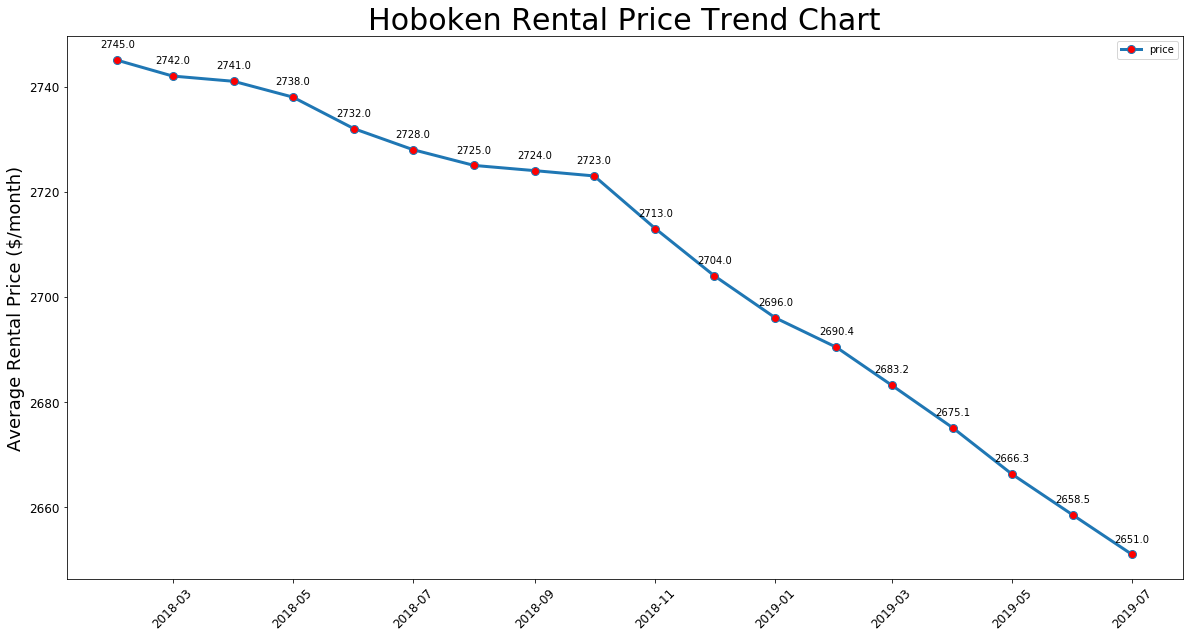

In [20]:
x = output['index'].tail(18)
y = output['price'].tail(18)

plt.figure(figsize = (20, 10))
plt.plot(x, y, linewidth = 3, marker = 'o', markerfacecolor='red', markersize=8)

plt.title('Hoboken Rental Price Trend Chart', fontsize = 30)
plt.ylabel('Average Rental Price ($/month)', fontsize = 18)
# plt.ylim((2650,2775))
plt.tick_params(labelsize = 12)
plt.xticks(rotation = 45)
for i, j in zip(x, y):
    plt.text(i, j + 2, j, ha = 'center', va = 'bottom', fontsize = 10)
    
plt.legend()
plt.savefig("../area_predict_pics/Hoboken.jpg")
plt.show()

In [21]:
# m = df['date'].tail(18)
# n = df['price'].tail(18)
# plt.figure(figsize = (20, 10))
# plt.plot(m, n, linewidth = 3, marker = 'o', markerfacecolor='red', markersize=8)
# plt.title('Hoboken Rental Price Trend Chart', fontsize = 30)
# plt.ylabel('Average Rental Price ($/month)', fontsize = 18)
# plt.tick_params(labelsize = 12)
# plt.xticks(rotation = 90)
# for i, j in zip(m, n):
#     plt.text(i, j + 2, j, ha = 'center', va = 'bottom', fontsize = 10)
# plt.show()